## Import libraries

In [70]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob

from xgboost import XGBRegressor
from xgboost import plot_importance

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Define reusable functions

#### Function for reading data from model dataset

In [71]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    return df_data

#### Function for performing Dickey-Fuller Stationarity test for time series data

In [72]:
# Check if time series data is stationary
def dickey_fuller_test(time_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

#### Function for calculating *Mean Absolute Percentage Error* and *Root Mean Squared Error*

In [73]:
# Calculate Mean Absolute Percentage Error and Root Mean Squared Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

#### Function for executing Holt Winter Exponential Smoothing forecast
Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

In [74]:
def holt_winter(train_data, test_data, seasonal_periods, trend, seasonal):
    hw_model = ExponentialSmoothing(train_data, seasonal_periods = seasonal_periods, trend = trend, seasonal = seasonal)
    hw_fit = hw_model.fit()
    hw_pred = hw_fit.forecast(len(test_data))
    return(hw_pred)

#### Function for executing ARIMAX forecast

In [75]:
def arimax(train_data, test_data, freq):

    sarimax_model = auto_arima(train_data, start_p = 0, start_q = 0
                                ,max_p = 3, max_q = 3
                                , m = freq # the frequncy of the cycle
                                , test = 'adf', seasonal = True #set to seasonal
                                , d=1, D=1, trace = True, error_action = 'ignore'
                                , suppress_warnings = True, stepwise = True)

    model_order = sarimax_model.get_params()['order']
    model_seasonal_order = sarimax_model.get_params()['seasonal_order']

    sr_model = SARIMAX(train_data, order = model_order, seasonal_order = model_seasonal_order)
    sr_model_fit = sr_model.fit()
    print(sr_model_fit.summary()) 

    sr_pred = sr_model_fit.forecast(len(test_data))
    return(sr_pred)

#### Function for reviewing results of multiple models

In [76]:
def mod_review(models, demand_name):
    plt.figure(figsize=(12,5))

    for name, y_pred in models.items():
        mape, rmse = accuracy(y_test, y_pred)
        print('================================================================')
        print(name)
        print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
        print('Root Mean Square Error : {}'.format(rmse))
    
        # Plot forecast
        plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

    plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
    plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
    plt.xlabel('Time', fontsize=10)
    plt.ylabel(demand_name, fontsize=10)
    plt.legend(loc='best')
    plt.title(f'{demand_name} Forecast', fontsize=12)
    plt.show()

#### Read pre-processed multi-variable dataset

#### Set python variables

In [77]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Set the period of forecast from 2011 to 2020
start_mth = datetime.datetime(2011, 1, 1)
end_mth = datetime.datetime(2020, 12, 1)

#### Read dataset into pandas dataframe

In [78]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

In [79]:
# Convert date column to datetime datatype
df_model_data['date'] = pd.to_datetime(df_model_data['date'])

# Set dataframe index to date column
df_model_data.index = df_model_data.date

# Filter records within start and end month
df_model_data = df_model_data[( df_model_data['date']>=start_mth) & (df_model_data['date'] <= end_mth)]

#### Plot Seasonality and Trend in Timeseries for Average Daily Maximum Demand

In [80]:
pivot_df = df_model_data.pivot_table(index='month', columns='year', values='demand_avg_daily_max')

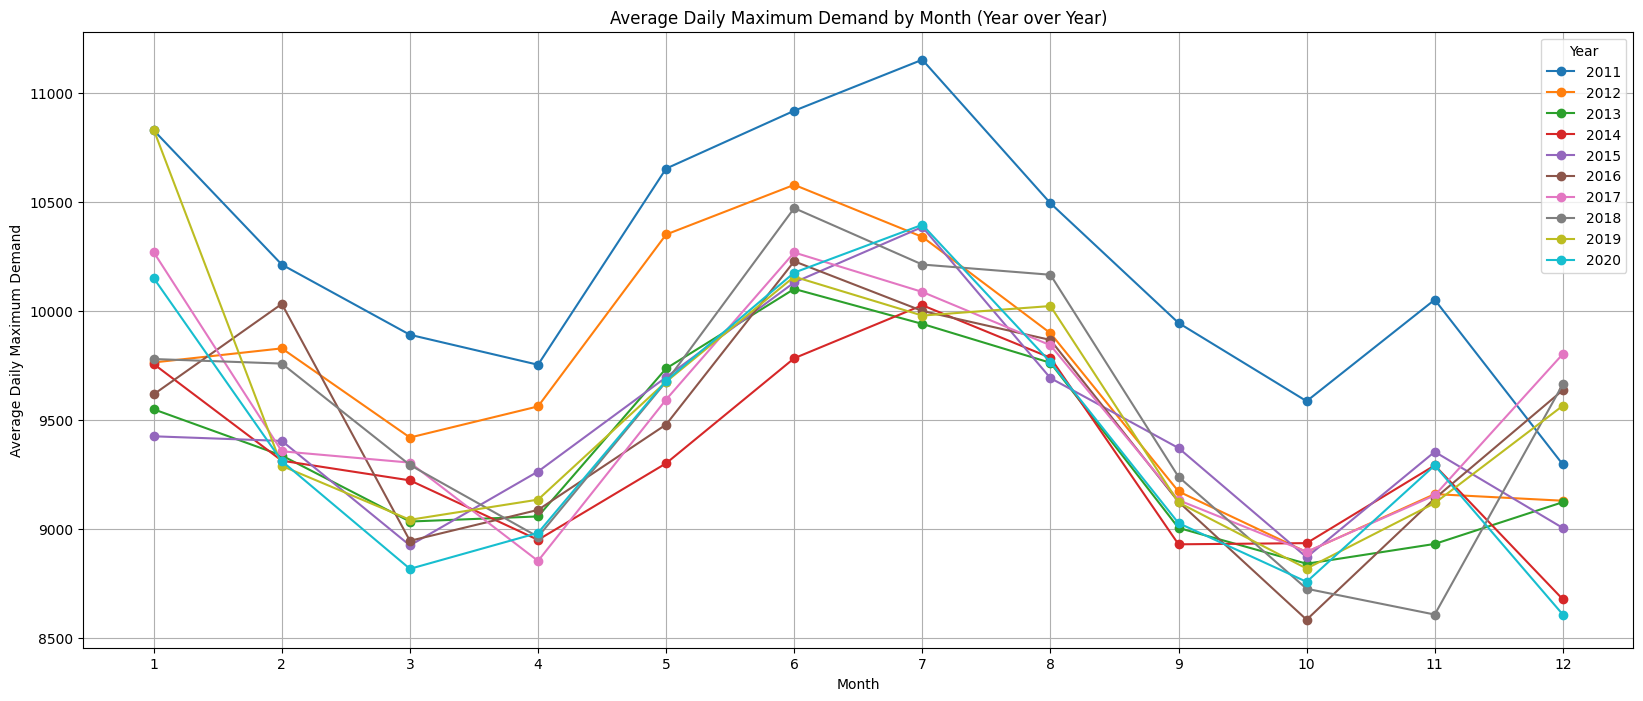

In [81]:
# Plot the line chart
pivot_df.plot(kind='line', marker='o', figsize=(20, 8))
plt.title('Average Daily Maximum Demand by Month (Year over Year)')
plt.xlabel('Month')
plt.ylabel('Average Daily Maximum Demand')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.legend(title='Year', loc='best')
plt.show()

In [82]:
print(df_model_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-01-01 to 2020-12-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  120 non-null    int64         
 1   month                 120 non-null    int64         
 2   date                  120 non-null    datetime64[ns]
 3   temp_mean             120 non-null    float64       
 4   temp_min              120 non-null    float64       
 5   temp_max              120 non-null    float64       
 6   temp_avg_daily_min    120 non-null    float64       
 7   temp_avg_daily_max    120 non-null    float64       
 8   degree_days           120 non-null    float64       
 9   demand_mean           120 non-null    float64       
 10  demand_max            120 non-null    float64       
 11  demand_avg_daily_max  120 non-null    float64       
 12  total_consumption     120 non-null    float64       
 13  p

#### Perform Dicky-Fuller Test for Stationarity of Timeseries data for all demand variables

Results of Dickey-Fuller Test:
Test Statistic                  -4.025833
p-value                          0.001281
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


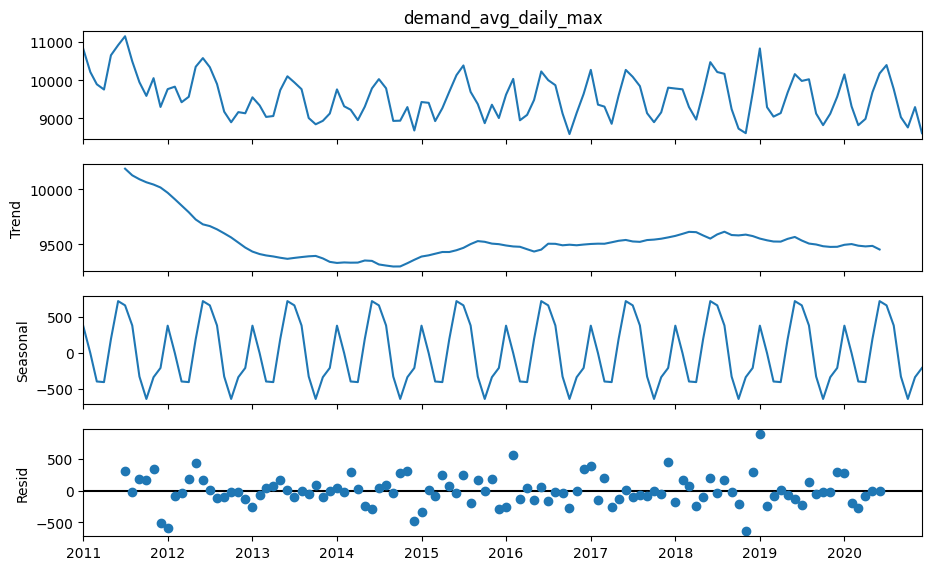

In [83]:
# Apply Dickey-Fuller test for Average Daily Maximum Demand
dickey_fuller_test(df_model_data.demand_avg_daily_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_avg_daily_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

Results of Dickey-Fuller Test:
Test Statistic                -6.764720e+00
p-value                        2.735563e-09
#Lags Used                     0.000000e+00
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64


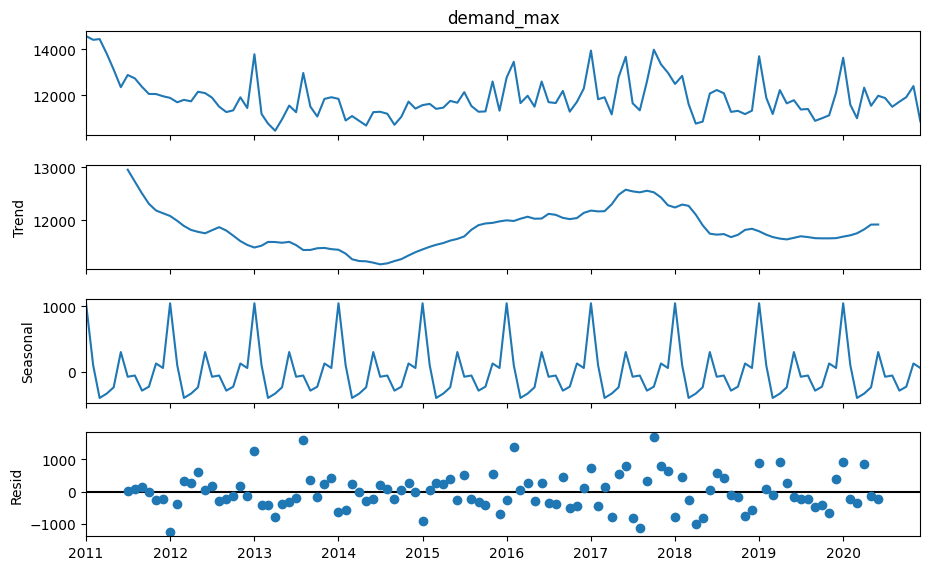

In [84]:
# Apply Dickey-Fuller test for Maximum (Peak) Demand
dickey_fuller_test(df_model_data.demand_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.001382
p-value                          0.285967
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


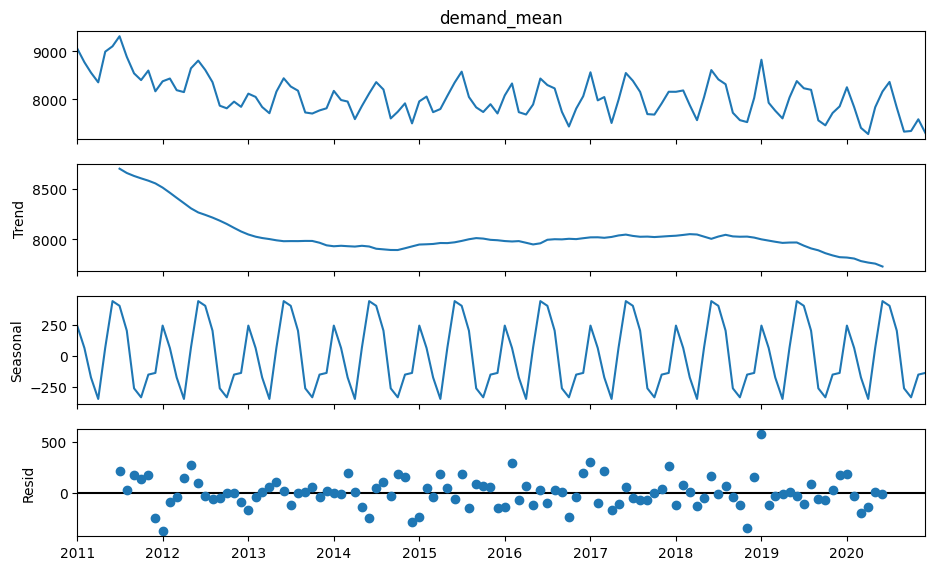

In [85]:
# Apply Dickey-Fuller test for Mean Demand
dickey_fuller_test(df_model_data.demand_mean)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_mean)
fig = decomp.plot()
fig.set_size_inches(10,6)

#### Prepare data for time series models

In [86]:
# Set the forecast window to 24 months
forecast_mths = 24 

# Create test and train subsets, where test holds all rows for the last 24 months
train = df_model_data[ : -forecast_mths]
test = df_model_data[-forecast_mths :]

y_train_adm = train['demand_avg_daily_max']
y_test_adm = test['demand_avg_daily_max']

y_train_max = train['demand_max']
y_test_max = test['demand_max']

y_train_mean = train['demand_mean']
y_test_mean = test['demand_mean']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))


Train size: 96 , Test size: 24


#### Run Holt Winter Exponential Smoothing forecast for *Average Daily Maximum Demand*

In [87]:
y_train = y_train_adm
y_test = y_test_adm

In [88]:

# Holt Winter Forecast

hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')


C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Run ARIMAX forecast for *Average Daily Maximum Demand*

In [89]:
sr_pred = arimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1212.971, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1224.826, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1194.857, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1174.140, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1183.909, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1175.566, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1174.786, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1179.774, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1175.725, Time=0.83 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1211.498, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1176.140, Time=0.26 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1176.140, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1188.111, Time=0.17 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[12]

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Review results of Holt Winter and ARIMAX forecasts for *Average Daily Maximum Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 2.07%
Root Mean Square Error : 307.0329387491813
ARIMAX
Mean Absolute Percentage Error (MAPE) : 2.57%
Root Mean Square Error : 350.4062788513483


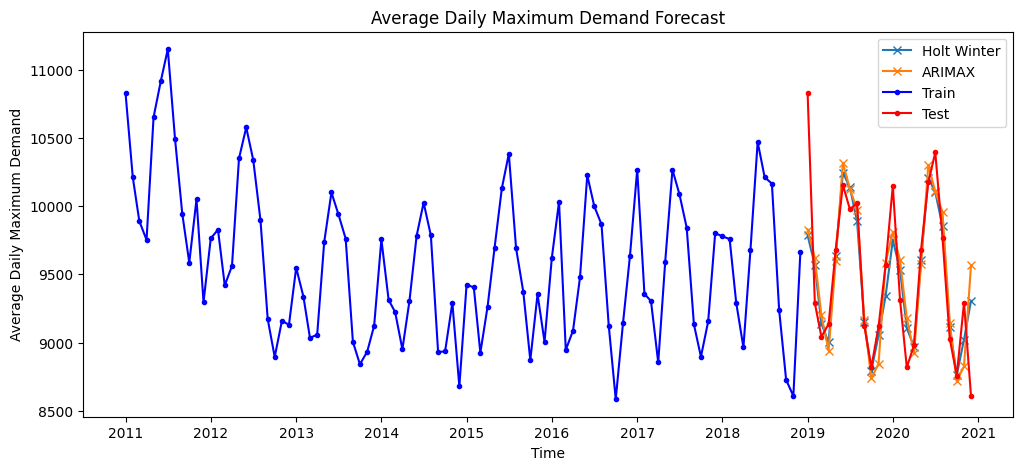

In [90]:
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

#### Run Holt Winter Exponential Smoothing forecast for *Maximum (Peak) Demand*

In [91]:
y_train = y_train_max
y_test = y_test_max

In [92]:
# Holt Winter Forecast

hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Run ARIMAX forecast for *Maximum (Peak) Demand*

In [93]:
sr_pred = arimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1373.966, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1405.690, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1379.149, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1368.186, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1395.667, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1370.181, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1370.181, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1376.998, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1372.025, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1362.229, Time=0.36 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1389.030, Time=0.12 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=1364.162, Time=0.73 sec
 ARIMA(0,1,2)(0,1,2)[12]     

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           demand_max   No. Observations:                   96
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -675.192
Date:                              Tue, 16 Apr 2024   AIC                           1360.384
Time:                                      03:15:37   BIC                           1372.478
Sample:                                  01-01-2011   HQIC                          1365.243
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3664      0.074     -4.950      0.000      -0.511      -0.221
ma.L2         -0.22

#### Review results of Holt Winter and ARIMAX forecasts for *Maximum (Peak) Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 6.62%
Root Mean Square Error : 999.9113582781748
ARIMAX
Mean Absolute Percentage Error (MAPE) : 4.35%
Root Mean Square Error : 647.2367194122577


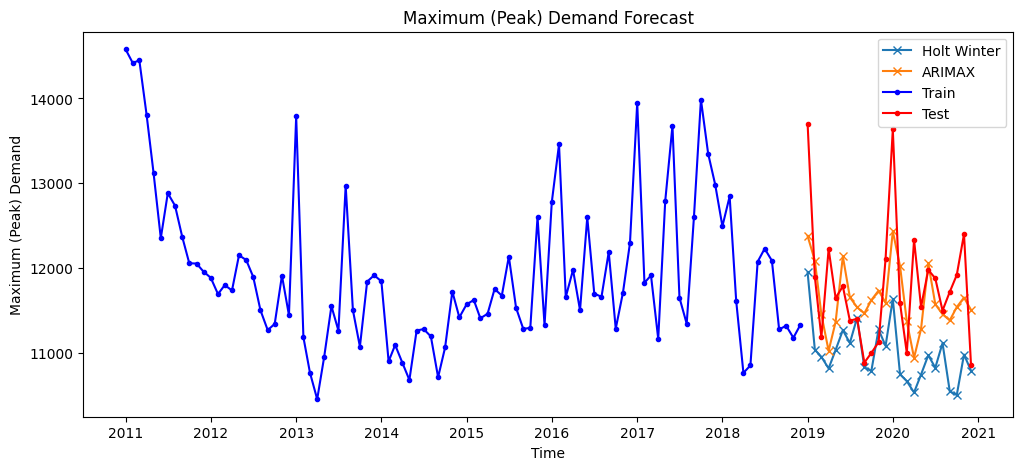

In [94]:
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
}
mod_review(models=models, demand_name='Maximum (Peak) Demand')

#### Run Holt Winter Exponential Smoothing forecast for *Mean Demand*

In [95]:
y_train = y_train_mean
y_test = y_test_mean

In [96]:
# Holt Winter Forecast

hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


#### Run ARIMAX forecast for *Mean Demand*

In [97]:
sr_pred = arimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1139.432, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1158.502, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1124.927, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1105.740, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1119.505, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1107.542, Time=0.33 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1107.296, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1112.644, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1137.490, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1107.733, Time=0.32 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1107.734, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1116.584, Time=0.32 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(0,1,1)[12] inte

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Review results of Holt Winter and ARIMAX forecasts for *Mean Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 2.00%
Root Mean Square Error : 217.04545398070073
ARIMAX
Mean Absolute Percentage Error (MAPE) : 2.29%
Root Mean Square Error : 242.81192479603757


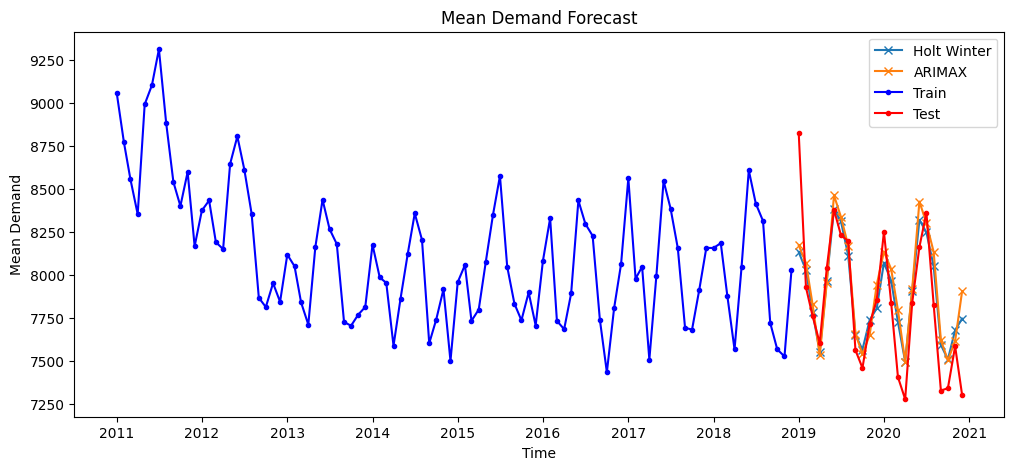

In [98]:
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
}
mod_review(models=models, demand_name='Mean Demand')